In [29]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 0. Data load

In [30]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
df_cleaned = df[['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining', 'midPrice']].copy()
df_cleaned = df_cleaned.dropna()
df_cleaned['inTheMoney'] = df_cleaned['inTheMoney'].astype('category')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132230 entries, 0 to 146087
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   strike             132230 non-null  float64 
 1   volume             132230 non-null  float64 
 2   openInterest       132230 non-null  float64 
 3   impliedVolatility  132230 non-null  float64 
 4   inTheMoney         132230 non-null  category
 5   price              132230 non-null  float64 
 6   duration           132230 non-null  int64   
 7   remaining          132230 non-null  int64   
 8   midPrice           132230 non-null  float64 
dtypes: category(1), float64(6), int64(2)
memory usage: 9.2 MB


In [32]:
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64'])
categorical_cols = df_cleaned.select_dtypes(include=['category'])

### 2. Data split

In [4]:
INPUTS = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining']
OUTPUT= 'midPrice'

X = df_cleaned[INPUTS]
y = df_cleaned[OUTPUT]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

strike  volume  openInterest  impliedVolatility inTheMoney   price  \
99940    121.0     1.0           1.0           0.397467      False  108.84   
108329   700.0    53.0        1664.0           0.254799      False  666.30   
29334     62.5     2.0          15.0           0.405035      False   55.93   
86943    230.0     1.0           5.0           1.152470       True  643.58   
117109   195.0     1.0         279.0           0.557622       True  250.80   

        duration  remaining  
99940         29         29  
108329        22         22  
29334        601        596  
86943         83         78  
117109        31         22

In [5]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

In [ ]:
INPUTS_MLP_NUM = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'price', 'duration', 'remaining']
INPUTS_MLP_CAT = ['inTheMoney']
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.01, 0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(60,)],
         'MLP__learning_rate_init': [0.001, 0.01],
         'MLP__activation': ['relu', 'tanh']
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', 
                max_iter=2000, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid


# Save the model
import joblib
joblib.dump(MLP_fit, '../models/MLP_fit_complete.pkl')


Iteration 1, loss = 11645.40792715
Iteration 1, loss = 11357.03504604
Iteration 1, loss = 11499.57838974
Iteration 1, loss = 11509.43727654
Iteration 1, loss = 11458.16752610
Iteration 2, loss = 8872.67251239
Iteration 2, loss = 8772.14274705
Iteration 2, loss = 8732.25559506
Iteration 1, loss = 11416.66143073
Iteration 2, loss = 8594.56430053
Iteration 2, loss = 8732.13117181
Iteration 1, loss = 11372.84116210
Iteration 3, loss = 7268.65663357
Iteration 3, loss = 7326.70472009
Iteration 3, loss = 7119.46802658
Iteration 2, loss = 8741.28008227
Iteration 3, loss = 7226.75505597
Iteration 3, loss = 7239.06958712
Iteration 4, loss = 6738.96278770
Iteration 2, loss = 8658.56922061
Iteration 1, loss = 11450.07700974
Iteration 4, loss = 6635.05500966
Iteration 4, loss = 6806.47361360
Iteration 4, loss = 6742.31670347
Iteration 4, loss = 6743.05864400
Iteration 3, loss = 7240.39585492
Iteration 5, loss = 6452.53011193
Iteration 3, loss = 7154.13607319
Iteration 5, loss = 6510.78155377
Iterat

['../models/MLP_fit_complete.pkl']

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plotModelGridError(MLP_fit):
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']
    params = results['params']

    # Convertir a error (RMSE)
    errors = np.sqrt(-mean_test_scores)

    # Etiquetas incluyendo todos los hiperparámetros relevantes
    param_labels = [
        f"act: {p['MLP__activation']}, alpha: {p['MLP__alpha']}, size: {p['MLP__hidden_layer_sizes']}, lr: {p['MLP__learning_rate_init']}"
        for p in params
    ]

    # Obtener todos los learning rates únicos para codificarlos por color
    lrs = [p['MLP__learning_rate_init'] for p in params]
    unique_lrs = sorted(set(lrs))
    lr_color_map = {lr: cm.viridis(i / len(unique_lrs)) for i, lr in enumerate(unique_lrs)}
    bar_colors = [lr_color_map[lr] for lr in lrs]

    # Ordenar por error creciente
    sorted_indices = np.argsort(errors)
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    bar_colors_sorted = [bar_colors[i] for i in sorted_indices]

    # Crear el gráfico
    plt.figure(figsize=(14, 10))
    bars = plt.barh(param_labels_sorted, errors_sorted, color=bar_colors_sorted)
    plt.xlabel("RMSE")
    plt.title("Errores del Modelo (RMSE) según Grid Search, agrupados por Learning Rate")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Crear leyenda manual
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=lr_color_map[lr]) for lr in unique_lrs
    ]
    legend_labels = [f"lr: {lr}" for lr in unique_lrs]
    plt.legend(legend_handles, legend_labels, title="Learning Rate", loc="lower right")

    plt.show()

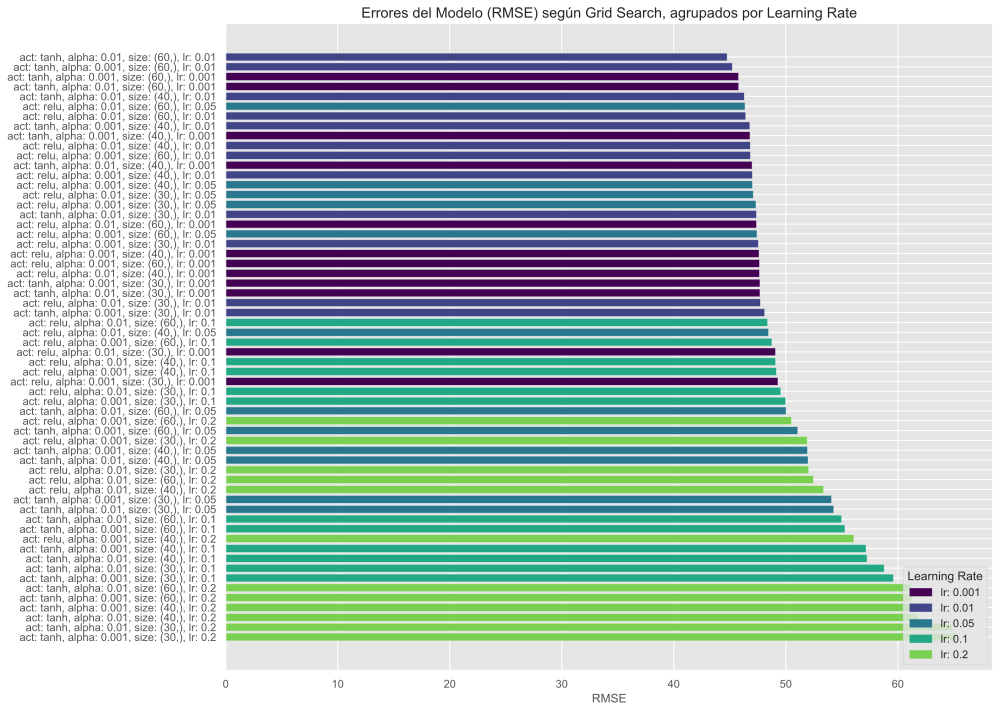

In [11]:
plotModelGridError(MLP_fit)
# La mejor combinación es ReLu, alpha=0.001, size=(60,), lr=0.1

In [15]:
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])

In [17]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

Training MAE: 12.171046970727938
Test MAE: 11.974535300829615
Training RMSE: 43.09509593082672
Test RMSE: 41.735268968417756
Training R2: 0.9156271013901798
Test R2: 0.9139827020654661


In [20]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [21]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()

Sensitivity analysis of [9, 60, 1] MLP network.

Sensitivity measures of each output:

$Y 

                              mean         std  mean_squared
num__strike            -224.460855  187.517861    292.481835
num__volume              -0.586423   35.432228     35.437081
num__openInterest         1.381353   23.824960     23.864971
num__impliedVolatility   17.171009  130.604189    131.728121
num__price              272.996693  196.478342    336.349421
num__duration             3.157973   99.403891     99.454041
num__remaining           27.000768   95.176523     98.932360
cat__inTheMoney_0.0     248.264889  435.681721    501.451909
cat__inTheMoney_1.0     445.309985  683.987242    816.173713


In [22]:
sensmlp.info()

Sensitivity analysis of [9, 60, 1] MLP network.

105784 samples

Sensitivities of each output (only 5 first samples):

$Y 

   num__strike  num__volume  num__openInterest  num__impliedVolatility  \
0   -44.678928     1.605755           0.919458               -0.460915   
1  -144.884378    -2.498796           6.295791               18.564064   
2   -74.676879    -1.128397          -3.546597                7.974613   
3  -568.163104   -53.025120          13.269423              -13.199785   
4  -436.610893    -9.137557           2.710455              -10.433104   

   num__price  num__duration  num__remaining  cat__inTheMoney_0.0  \
0   70.031485     -32.841315       34.767789          -124.603357   
1  153.828023      30.799832       27.360872            16.384025   
2  154.498808      18.258586      -15.221932            65.030565   
3  621.941529      49.241169       25.570310           990.574775   
4  472.495661      54.656221      -18.825608           598.976049   

   cat__inTheMon

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


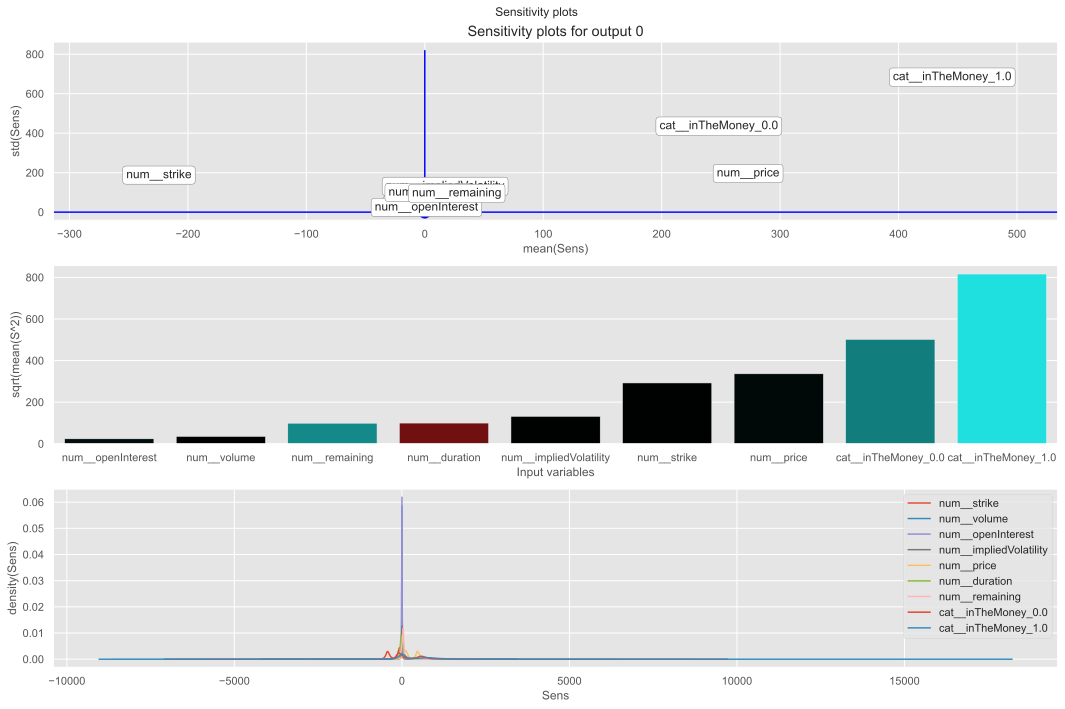

In [23]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

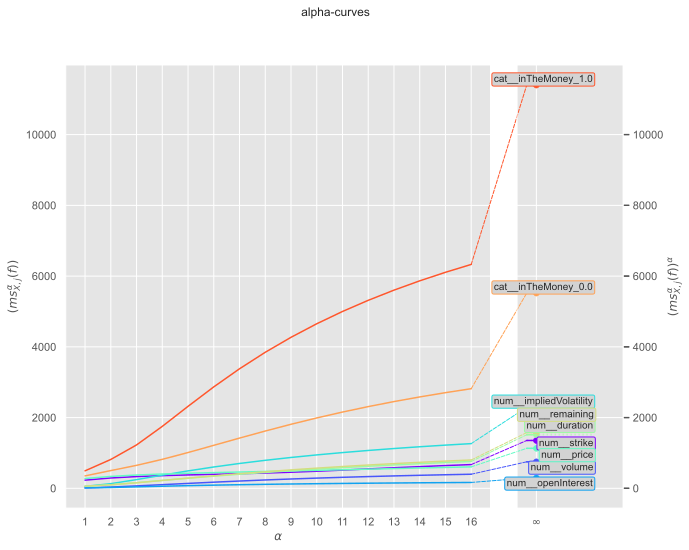

In [28]:
ns.alpha_sens_curves(sensmlp)

In [25]:
import inspect

In [26]:
print(inspect.getsource(ns.alpha_sens_curves))

def alpha_sens_curves(
    jacobian,
    tol: float = None,
    max_alpha: int = 16,
    alpha_step: int = 1,
    curve_equal_origin: bool = False,
    dev: str = "cpu",
    use_torch: bool = False,
    title: str = "alpha-curves",
    alpha_bar: int = 1,
    inp_var=None,
    kind: str = "line",
    figsize: tuple = (10, 8),
):
    """Generate plots of alpha curves of partial derivatives

    Args:
        jacobian (list[Float] | Jacobian_mlp): Object storing partial derivatives
        tol (float, optional): Minimum change between consecutive alpha-mean values to continue calculating
            means. If None, Defaults to None.
        max_alpha (int, optional): Maximum alpha value to calculate. Defaults to 100.
        alpha_step (int, optional): Specify increment between consecutive alphas. Defaults to 1.
        curve_equal_origin (bool, optional): Flag to specify if all alpha curves must begin at (1, 0).
            Defaults to False.
        dev (str, optional): device where ca